In [1]:
import pandas as pd

DATA_FILE = '../../data/chimpanzees.csv'

In [2]:
df = pd.read_csv(DATA_FILE)
df.head()

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
0,1,NaN,0,1,2,0,1,0
1,1,NaN,0,1,4,0,0,1
2,1,NaN,0,1,6,1,0,0
3,1,NaN,0,1,8,0,1,0
4,1,NaN,0,1,10,1,1,1


### Code 11.2

In [3]:
df['treatment'] = df['prosoc_left'] + 2 * df['condition']
df[['condition', 'prosoc_left', 'treatment']].drop_duplicates()

,condition,prosoc_left,treatment
0,0,0,0
2,0,1,1
36,1,0,2
38,1,1,3


In [4]:
df['actor'].drop_duplicates()

0      1
72     2
144    3
216    4
288    5
360    6
432    7
Name: actor, dtype: int64

## Model

\begin{align*}
    L_i & \sim \text{Binomial}(1, p_i) \\
    \log \frac{p_i}{1 - p_i} & = \alpha_{\text{actor}[i]} + \beta_{\text{treatment}[i]} \\
    \alpha_j & \sim \text{to be determined} \\
    \beta_j & \sim \text{to be determined}
\end{align*}

Here $L$ indicates the binary variable `pulled_left`; there are $7$ `$\alpha$ parameters`, one for each chimpanzee; there are $4$ `treatment` variables, one for each combination of the position of the pro-social option and the presence/absence of a partner.

## Priors for $\alpha$

The very first attempt consists of using a flat prior for $\alpha$.

\begin{align*}
    L_i & \sim \text{Binomial}(1, p_i) \\
    \log \frac{p_i}{1 - p_i} & = \alpha  \\
    \alpha & \sim \text{Normal}(0, \omega)
\end{align*}


In [25]:
import arviz as az
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from scipy import stats
from scipy.special import expit as logistic

warnings.simplefilter(action="ignore", category=FutureWarning)

### Code 11.4 - 11.6

In [6]:
with pm.Model() as m_11_1:
    a = pm.Normal('a', mu=0, sigma=10)
    p = pm.Deterministic('p', pm.math.invlogit(a))
    pulled_left = pm.Binomial('pulled_left', n=1, p=p, observed=df['pulled_left'])
    
    prior_11_1 = pm.sample_prior_predictive(4000)

In [7]:
prior_11_1

{'pulled_left': array([[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]]),
 'a': array([  8.89565331,   8.68919001, -10.27260083, ...,  -6.43173986,
          4.31132963,  23.6105978 ]),
 'p': array([9.99863036e-01, 9.99831632e-01, 3.45661599e-05, ...,
        1.60706104e-03, 9.86761899e-01, 1.00000000e+00])}

In [8]:
with pm.Model() as m_11_1_base:
    a = pm.Normal('a', mu=0, sigma=1.5)
    p = pm.Deterministic('p', pm.math.invlogit(a))
    pulled_left = pm.Binomial('pulled_left', n=1, p=p, observed=df['pulled_left'])
    
    prior_11_1_base = pm.sample_prior_predictive(4000)

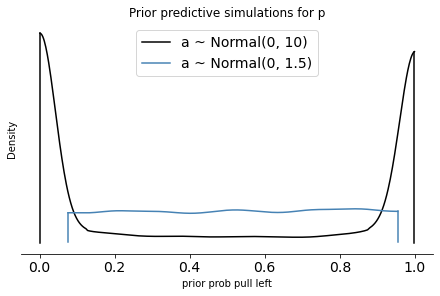

In [9]:
az.plot_density([prior_11_1['p'], prior_11_1_base['p']], 
                data_labels=['a ~ Normal(0, 10)', 'a ~ Normal(0, 1.5)'],
                colors=['k', 'steelblue'], 
                point_estimate=None);

plt.xlabel("prior prob pull left")
plt.ylabel("Density")
plt.title("Prior predictive simulations for p");

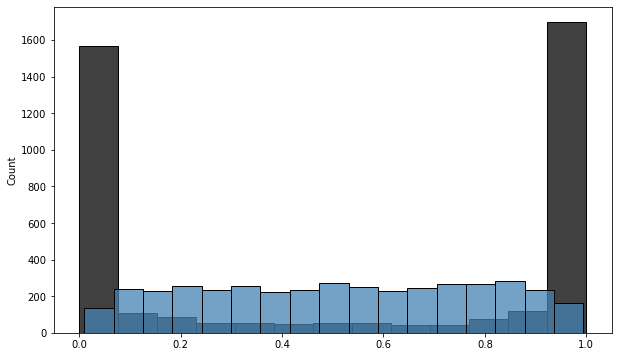

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

sns.histplot(prior_11_1['p'], ax=ax, color='k');
sns.histplot(prior_11_1_base['p'], ax=ax, color='steelblue');

## Priors for the treatment effects

### Code 11.7

In [11]:
with pm.Model() as m_11_2:
    a = pm.Normal('a', mu=0, sigma=1.5)
    b = pm.Normal('b', mu=0, sigma=10, shape=df['treatment'].nunique())
    p = pm.Deterministic('p', pm.math.invlogit(a + b[df['treatment']]))
    pulled_left = pm.Binomial('pulled_left', n=1, p=p, observed=df['pulled_left'])
    
    prior_11_2 = pm.sample_prior_predictive(4000)

In [12]:
prior_11_2['p'].shape

(4000, 504)

In [13]:
with pm.Model() as m_11_2_base:
    a = pm.Normal('a', mu=0, sigma=1.5)
    b = pm.Normal('b', mu=0, sigma=0.5, shape=df['treatment'].nunique())
    p = pm.Deterministic('p', pm.math.invlogit(a + b[df['treatment']]))
    pulled_left = pm.Binomial('pulled_left', n=1, p=p, observed=df['pulled_left'])
    
    prior_11_2_base = pm.sample_prior_predictive(4000)

In [14]:
prior_11_2_base['p'].shape

(4000, 504)

In [15]:
idx_0 = df[df['treatment'] == 0].index
idx_1 = df[df['treatment'] == 1].index
idx_2 = df[df['treatment'] == 2].index
idx_3 = df[df['treatment'] == 3].index

prior_p_11_2 = [prior_11_2['p'][:, idx] for idx in [idx_0, idx_1, idx_2, idx_3]]
prior_p_11_2_base = [prior_11_2_base['p'][:, idx] for idx in [idx_0, idx_1, idx_2, idx_3]]

In [16]:
for prior_p in prior_p_11_2:
    print(prior_p.shape)

(4000, 126)
(4000, 126)
(4000, 126)
(4000, 126)


### Code 11.8

In [17]:
abs_diff_0_1 = np.abs(prior_p_11_2[0].T - prior_p_11_2[1].T)
abs_diff_0_1_base = np.abs(prior_p_11_2_base[0].T - prior_p_11_2_base[1].T)
abs_diff_0_1.shape, abs_diff_0_1_base.shape

((126, 4000), (126, 4000))

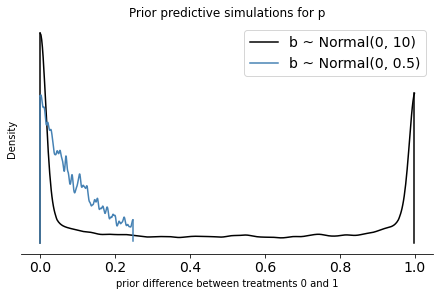

In [18]:
az.plot_density([abs_diff_0_1, abs_diff_0_1_base], 
                data_labels=['b ~ Normal(0, 10)', 'b ~ Normal(0, 0.5)'],
                colors=['k', 'steelblue'], 
                point_estimate=None);

plt.xlabel("prior difference between treatments 0 and 1")
plt.ylabel("Density")
plt.title("Prior predictive simulations for p");

### Code 11.9

In [19]:
abs_diff_0_1_base.mean()

0.09534441778711254

### Code 11.10

In [20]:
actor_ids, actors = pd.factorize(df['actor'])
treatment_ids, treatment = pd.factorize(df['treatment'])

In [26]:
import theano.tensor as tt

with pm.Model() as m_11_4:
    a = pm.Normal('a', mu=0, sigma=1.5, shape=len(actors))
    b = pm.Normal('b', mu=0, sigma=0.5, shape=len(treatment))
    
    # This was taken verbatim from https://github.com/pymc-devs/resources/blob/master/Rethinking_2/Chp_11.ipynb
    # Not sure what this does
    actor_id = pm.intX(pm.Data('actor_id', actor_ids))
    treat_id = pm.intX(pm.Data('treat_id', treatment_ids))
    
    p = pm.Deterministic('p', pm.math.invlogit(a[actor_id] + b[treat_id]))
    
    # a_vect = tt.stack([a[idx] for idx in actor_ids])
    # b_vect = tt.stack([b[idx] for idx in treatment_ids])
    # p = pm.Deterministic('p', pm.math.invlogit(a_vect + b_vect))
    pulled_left = pm.Binomial('pulled_left', n=1, p=p, observed=df['pulled_left'])
    
    trace_11_4 = pm.sample(2000, tune=2000, return_inferencedata=False);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 17 seconds.


In [27]:
az.summary(trace_11_4, var_names=['a', 'b'], round_to=2, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.45,0.34,-0.99,0.09,0.01,0.00,2882.93,4660.99,1.0
a[1],3.88,0.75,2.71,5.04,0.01,0.01,5655.35,4419.69,1.0
a[2],-0.75,0.34,-1.30,-0.21,0.01,0.00,3013.04,4963.21,1.0
a[3],-0.75,0.34,-1.31,-0.21,0.01,0.00,2878.44,4848.30,1.0
a[4],-0.45,0.34,-1.01,0.06,0.01,0.00,2865.31,5209.65,1.0
a[5],0.48,0.34,-0.06,1.04,0.01,0.00,2916.50,4766.55,1.0
a[6],1.96,0.43,1.25,2.60,0.01,0.00,4054.42,5519.37,1.0
b[0],-0.04,0.29,-0.50,0.42,0.01,0.00,2668.39,4681.01,1.0
b[1],0.48,0.29,0.02,0.96,0.01,0.00,2711.56,4541.27,1.0
b[2],-0.38,0.29,-0.85,0.08,0.01,0.00,2536.93,4590.39,1.0


## A Note on the columns in the summary

This is from the Stan online reference (https://mc-stan.org/rstan/reference/Rhat.html)

The `Rhat` function produces R-hat convergence diagnostic, which compares the between- and within-chain estimates for model parameters and other univariate quantities of interest. If chains have not mixed well (i.e., the between- and within-chain estimates don't agree), R-hat is larger than 1. We recommend running at least four chains by default and only using the sample if R-hat is less than 1.05. Stan reports R-hat which is the maximum of rank normalized split-R-hat and rank normalized folded-split-R-hat, which works for thick tailed distributions and is sensitive also to differences in scale.

The `ess_bulk` function produces an estimated Bulk Effective Sample Size (bulk-ESS) using rank normalized draws. Bulk-ESS is a useful measure for sampling efficiency in the bulk of the distribution (related e.g. to efficiency of mean and median estimates), and is well defined even if the chains do not have finite mean or variance.

The `ess_tail` function produces an estimated Tail Effective Sample Size (tail-ESS) by computing the minimum of effective sample sizes for 5% and 95% quantiles. Tail-ESS is a useful measure for sampling efficiency in the tails of the distribution (related e.g. to efficiency of variance and tail quantile estimates).

Both bulk-ESS and tail-ESS should be at least 100 (approximately) per Markov Chain in order to be reliable and indicate that estimates of respective posterior quantiles are reliable.
